# Amazon Food Reviews - [Decision Trees]

Data Source:https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/NewCover.png)

## Excerpt 
1. Applied Decision Trees on Different Featurization of Data viz. BOW(uni-gram,bi-gram), tfidf, Avg-Word2Vec(using Word2Vec model pretrained on Google News) and tf-idf-Word2Vec <br>
2. Used both Grid Search with random 30 points for getting the best max_depth <br>
3. Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted Confusion matrix using seaborne<br>
4. Plotted feature importance recieved from the decision tree classifier<br>

#### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/AmazonReview.png)


### Objective:- Review Polarity
Given a review, determine the review is positive or negative

#### Using text review to decide the polarity
Take the summary and text of review and analyze it using NLP whether the customer feedback/review is positive or negative


In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

### Loading the data

In [4]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [5]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [6]:
df.shape
df['Score'].size

364171

## For EDA and Text Preprecessing Refer other ipynb notebook<b>

In [7]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "Positive":
        return 0
    else:
        return 1
df["Score"] = df["Score"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [8]:
#Taking Sample Data
n_samples = 50000
df_sample = df.sample(n_samples)

###Sorting as we want according to time series
df_sample.sort_values('Time',inplace=True) 
df_sample.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
169328,212519,230334,B00004RYGX,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,0,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,b'beetlejuic wonder amus comed romp explor inc...,b'beetlejuice wonderfully amusing comedic romp...
169304,212495,230309,B00004RYGX,A34NBH479RB0E,"""dmab6395""",0,1,0,977184000,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",b'thought movi funni michael keaton beetlejuic...,b'thought movie funny michael keaton beetlejui...
169340,212531,230346,B00004RYGX,A1ZH086GZYL5MZ,Doug DeBolt,2,2,0,1013385600,"A little gross, a lot of fun",Michael Keaton was already on his way to being...,b'michael keaton alreadi way major star play g...,b'michael keaton already way major star played...
169256,212447,230258,B00004RYGX,AEPJYN0NAX9N4,Jody L. Schoth,0,0,0,1014163200,Excellent... Hilarious,Just hilarious... my favorite part is the dini...,b'hilari favorit part dine room scene sing dan...,b'hilarious favorite part dining room scene si...
169339,212530,230345,B00004RYGX,ADIDQRLLR4KBQ,"""paradise_found""",2,2,0,1015545600,Because My Middle Name is &quot;Weird&quot;,"Set in a small New England town, Tim Burton's ...",b'set small new england town tim burton master...,b'set small new england town tim burtons maste...
169255,212446,230257,B00004RYGX,A1OP3SQP78M1PP,James Gowen,0,0,0,1015718400,"A movie to ""literally die for!!!""",Beetlejuice is not a movie that you can't watc...,b'beetlejuic not movi cant watch time one funi...,b'beetlejuice not movie cant watch times one f...
117347,138014,149785,B00004S1C6,A1KZ8KEBD4FONY,W. Zientek-Sico,60,61,0,1035504000,Wonderful product gives professional results,The spectra paste food colors are simply fanta...,b'spectra past food color simpli fantast provi...,b'spectra paste food colors simply fantastic p...
169331,212522,230337,B00004RYGX,A1CAA94EOP0J2S,Travis J Smith,4,4,0,1036022400,Great Comedy,Beetlejuice is the story of ghosts (Alec Baldw...,b'beetlejuic stori ghost alec baldwin geena da...,b'beetlejuice story ghosts alec baldwin geena ...
161885,202469,219388,B00005IX98,A24IUOMVERXVEG,"Rick ""rick_street""",11,11,0,1036108800,Great Easy cup of Espresso,I've purchased both the Espressione Espresso (...,b'ive purchas espression espresso classic arab...,b'ive purchased espressione espresso classic a...
117266,137933,149701,B00006L2ZT,A2STZ646VQE8QI,anomalogue,1,3,0,1036540800,This is the best Camper Van Beethoven,This is a beautiful repackaging of Camper Van...,b'beauti repackag camper van beethoven first t...,b'beautiful repackaging camper van beethovens ...


In [9]:
#Saving 50k samples in disk to as to test to test on the same sample for each of all Algo
savetofile(df_sample,"sample_dt")

In [2]:
#Opening from samples from file
df_sample = openfromfile("sample_dt")

# Decision Trees Model  using Different Featurization in NLP

![alt text](https://image.slidesharecdn.com/decision-tree-final-170421102129/95/decision-tree-algorithm-analysis-machine-learning-algorithm-data-science-training-edureka-12-638.jpg?cb=1492771312)

Here I have use GINI Impurity for building decision trees

![img](https://chrisalbon.com/images/machine_learning_flashcards/Gini_Index_print.png)

## Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.<br>
OR <br>
Simply,Converting a collection of text documents to a matrix of token counts

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (35000, 42258)
Test Data Size:  (15000, 42258)


In [21]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(3190, 42258) (3181, 42258)
(6371, 42258) (3181, 42258)
(9552, 42258) (3181, 42258)
(12733, 42258) (3181, 42258)
(15914, 42258) (3181, 42258)
(19095, 42258) (3181, 42258)
(22276, 42258) (3181, 42258)
(25457, 42258) (3181, 42258)
(28638, 42258) (3181, 42258)
(31819, 42258) (3181, 42258)


![i](https://i.stack.imgur.com/fXZ6k.png)

### Finding the best 'max_depth' using Forward Chaining Cross Validation or Time Series CV 

In [22]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
savetofile(gsv,"Decision Trees/gsv_uni")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 41.4min finished


Best HyperParameter:  {'max_depth': 291}
Best Accuracy: 42.23%


<b>Note: Not ideal to run Decision Trees on data with such huge features as it will take very long hours to train hence taking only 300 as max depth<b>

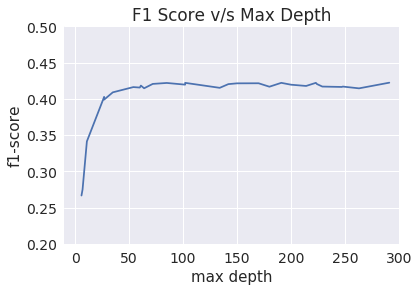

In [60]:
gsv = openfromfile("Decision Trees/gsv_uni")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(-10,300)
plt.ylim(0.2,0.5)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

Accuracy on test set: 83.447%
Precision on test set: 0.516
Recall on test set: 0.455
F1-Score on test set: 0.483
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



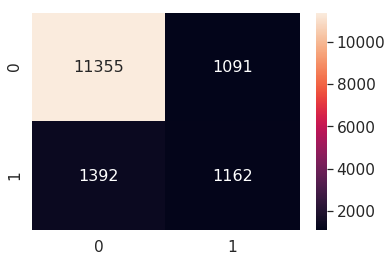

In [5]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=291)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

![alt](https://chrisalbon.com/images/machine_learning_flashcards/Feature_Importance_print.png)

### Top 25 most important features

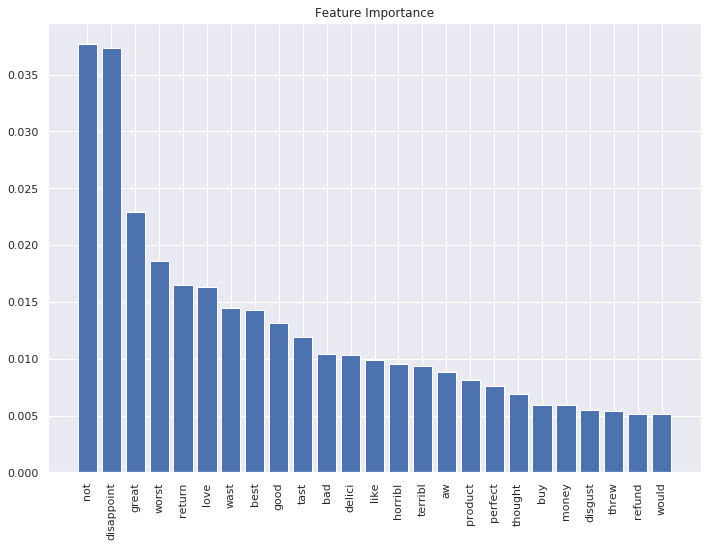

In [15]:
# Calculate feature importances from decision trees
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = uni_gram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

### bi-gram

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (35000, 637926)
Test Data Size:  (15000, 637926)


In [25]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
savetofile(gsv,"Decision Trees/gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 201.8min finished


Best HyperParameter:  {'max_depth': 73}
Best Accuracy: 46.25%


<b>Note: Not ideal to run Decision Trees on data with such huge features as it will take very long hours to train hence taking only 300 as max depth<b>

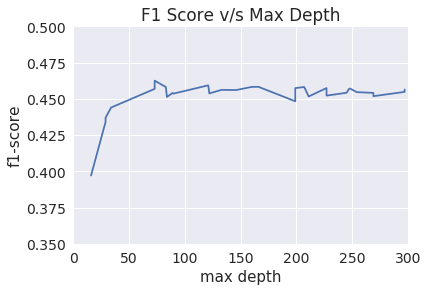

In [59]:
gsv = openfromfile("Decision Trees/gsv_bi")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,300)
plt.ylim(0.35,0.5)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

Accuracy on test set: 85.120%
Precision on test set: 0.578
Recall on test set: 0.467
F1-Score on test set: 0.517
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



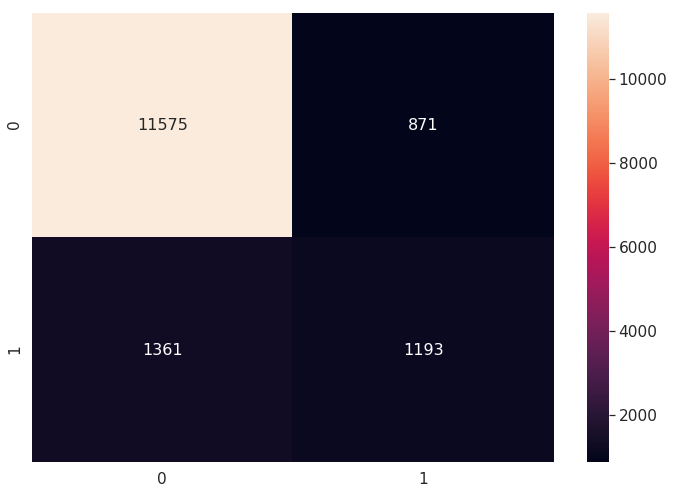

In [17]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=73)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Top 25 most important features

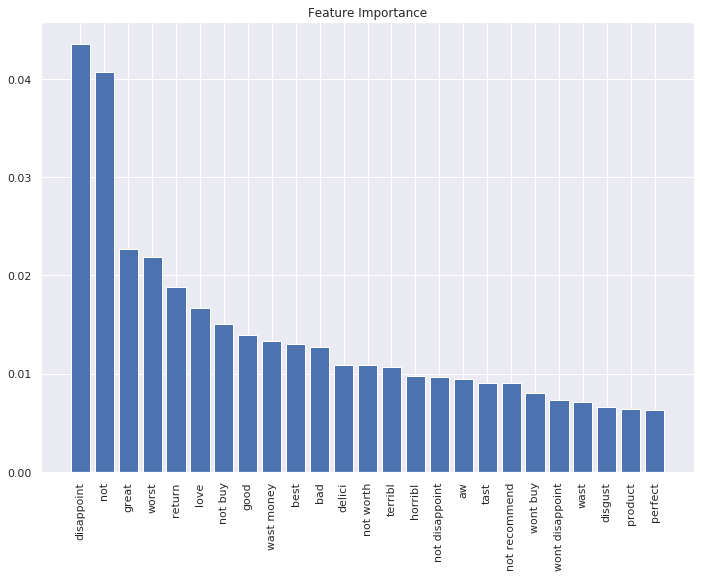

In [19]:
# Calculate feature importances from decision trees
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = bi_gram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

# tf-idf


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/01/11181616/image-4.png)

In [20]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (35000, 637926)
Test Data Size:  (15000, 637926)
CPU times: user 7.73 s, sys: 36 ms, total: 7.76 s
Wall time: 7.77 s


In [28]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
savetofile(gsv,"Decision Trees/gsv_tfidf")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 207.1min finished


Best HyperParameter:  {'max_depth': 231}
Best Accuracy: 46.51%


<b>Note: Not ideal to run Decision Trees on data with such huge features as it will take very long hours to train hence taking only 300 as max depth<b>

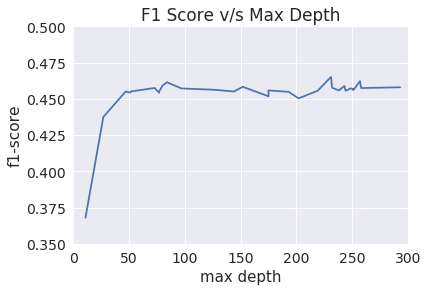

In [58]:
gsv = openfromfile("Decision Trees/gsv_tfidf")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,300)
plt.ylim(0.35,0.5)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

Accuracy on test set: 84.427%
Precision on test set: 0.545
Recall on test set: 0.515
F1-Score on test set: 0.530
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



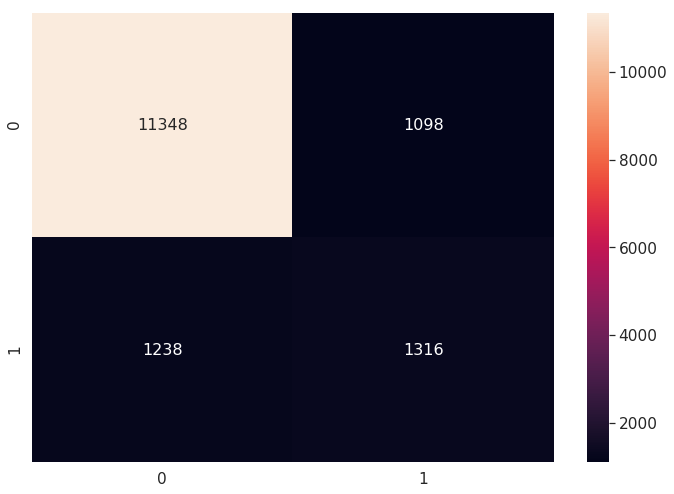

In [21]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=231)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Top 25 most important features

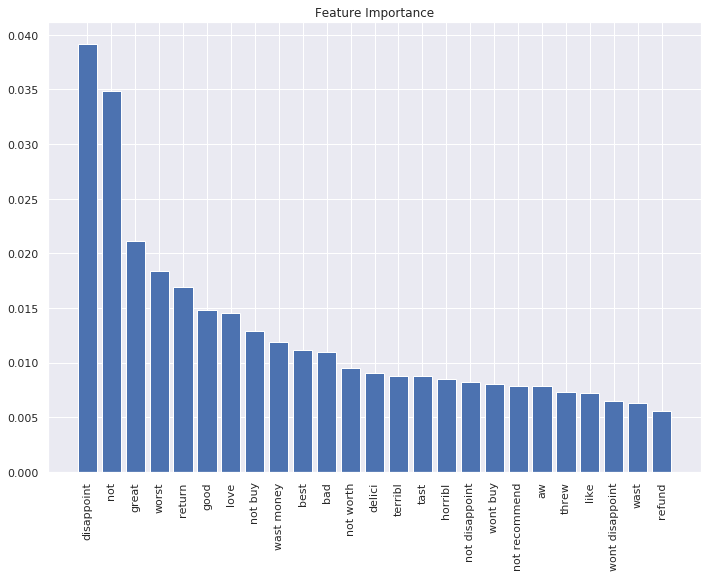

In [22]:
# Calculate feature importances from decision trees
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = tfidf.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

## Gensim
Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections, using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software packages that only target batch and in-memory processing.

## Word2Vec
[Refer Docs] :https://radimrehurek.com/gensim/models/word2vec.html 

In [6]:
from gensim.models import KeyedVectors

#Loading the model from file in the disk
w2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In [7]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

3000000

## Avg Word2Vec
* One of the most naive but good ways to convert a sentence into a vector
* Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence 

In [66]:
%%time
avg_vec_google = [] #List to store all the avg w2vec's 
# no_datapoints = 364170
# sample_cols = random.sample(range(1, no_datapoints), 20001)
for sent in df_sample['CleanedText_NoStem']:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt #Taking average of vectors sum of the particular review
#     print("avg_vec:",sent_vec)
    avg_vec_google.append(sent_vec) #Storing the avg w2vec's for each review
#     print("*******************************************************************")
# print(avg_vec_google)
avg_vec_google = np.array(avg_vec_google)

CPU times: user 24.1 s, sys: 56 ms, total: 24.2 s
Wall time: 24.2 s


In [67]:
np.isnan(avg_vec_google).any()

False

In [68]:
mask = ~np.any(np.isnan(avg_vec_google), axis=1)
# print(mask)
avg_vec_google_new = avg_vec_google[mask]
df_sample_new = df_sample['Score'][mask]
print(avg_vec_google_new.shape)
print(df_sample_new.shape)

(50000, 300)
(50000,)


In [69]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(avg_vec_google_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample_new.values,test_size=0.3,shuffle=False)

In [13]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
savetofile(gsv,"Decision Trees/gsv_aw2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 93.9min finished


Best HyperParameter:  {'max_depth': 20}
Best Accuracy: 31.83%


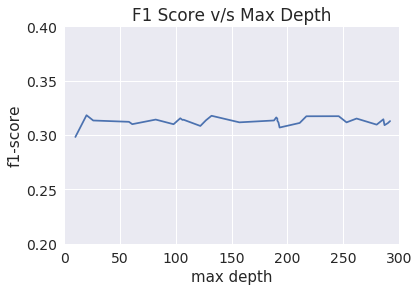

In [65]:
gsv = openfromfile("Decision Trees/gsv_aw2v")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,300)
plt.ylim(0.2,0.4)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

Accuracy on test set: 79.380%
Precision on test set: 0.380
Recall on test set: 0.333
F1-Score on test set: 0.355
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



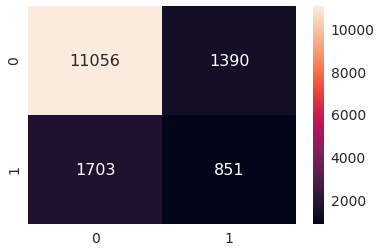

In [71]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=20)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [15]:
importances = clf.feature_importances_
print(importances)

[ 0.00175945  0.00349239  0.01029238  0.00340061  0.0131046   0.00225063
  0.00292788  0.00128508  0.00468368  0.00255785  0.00348384  0.00467724
  0.00243404  0.00283186  0.00357978  0.00191578  0.00231668  0.00237386
  0.00143282  0.00589543  0.00219676  0.00083783  0.00210978  0.0021752
  0.00601339  0.00354034  0.01229339  0.00165709  0.00331596  0.00707421
  0.00249374  0.0007818   0.00481606  0.00156479  0.00227053  0.00379202
  0.0062249   0.0032119   0.00117164  0.0009885   0.0010391   0.00333548
  0.00292439  0.00337951  0.00043645  0.00096249  0.00078105  0.00324372
  0.00570326  0.00180966  0.00076963  0.00335505  0.00047165  0.00237379
  0.00217202  0.00327203  0.00207924  0.00312069  0.00238702  0.00067064
  0.00195518  0.00306831  0.00040049  0.00112416  0.03474253  0.00416799
  0.00461279  0.00421409  0.00197815  0.00273081  0.00317363  0.00448606
  0.0019258   0.00417622  0.00391924  0.00376488  0.00197057  0.0012056
  0.00359533  0.00099015  0.00400184  0.00546367  0.0

But since the features in Word2Vec aren't interpretable its needless to get the feature importance

## Tf-idf W2Vec
* Another way to covert sentence into vectors
* Take weighted sum of the vectors divided by the sum of all the tfidf's 
<br>i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [11]:
%%time
#Taking Sample Data as it was taking more that 10 hours to computer this block
n_samples = 25000
df_sample_new = df_sample.sample(n_samples)

###Sorting as we want according to time series
df_sample_new.sort_values('Time',inplace=True) 

###tf-idf with No Stemming
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams

tfidf_vec_new = tfidf.fit_transform(df_sample_new['CleanedText_NoStem'].values)

print(tfidf_vec_new.shape)

# tf-idf came up with 2.9 million features for the data corpus
# from sklearn.decomposition import TruncatedSVD

# tsvd_tfidf_ns = TruncatedSVD(n_components=300)#No of components as total dimensions
# tsvd_tfidf_vec_ns = tsvd_tfidf_ns.fit_transform(tfidf_vec_ns)
# print(tsvd_tfidf_ns.explained_variance_ratio_[:].sum())
features = tfidf.get_feature_names()

(25000, 589499)
CPU times: user 6.15 s, sys: 16 ms, total: 6.16 s
Wall time: 6.16 s


In [ ]:
%%time
tfidf_w2v_vec_google = []
review = 0

for sent in df_sample_new['CleanedText_NoStem'].values:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("w2vec:",wvec)
#             print("tfidf:",tfidf_vec_ns[review,features.index(word)])
            tfidf_vec = tfidf_vec_new[review,features.index(word)]
            sent_vec += (wvec * tfidf_vec)
            weighted_sum += tfidf_vec
        except:
#             print(review)
            pass
    sent_vec /= weighted_sum
#     print(sent_vec)
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1
tfidf_w2v_vec_google = np.array(tfidf_w2v_vec_google)
savetofile(tfidf_w2v_vec_google,"tfidf_w2v_vec_google")

In [72]:
#Precomputed File
tfidf_w2v_vec_google = openfromfile("tfidf_w2v_vec_google")
#Loading the same samples as using precomuted file
df_sample_new = openfromfile("df_sample_new_tfidfw2vec")

In [73]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,df_sample_new['Score'].values,test_size=0.3,shuffle=False)

In [76]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
savetofile(gsv,"Decision Trees/gsv_tfidfaw2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 44.0min finished


Best HyperParameter:  {'max_depth': 57}
Best Accuracy: 29.07%


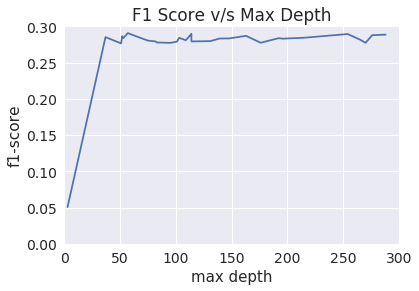

In [79]:
gsv = openfromfile("Decision Trees/gsv_tfidfaw2v")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,300)
plt.ylim(0.0,0.3)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

Accuracy on test set: 77.093%
Precision on test set: 0.298
Recall on test set: 0.310
F1-Score on test set: 0.304
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



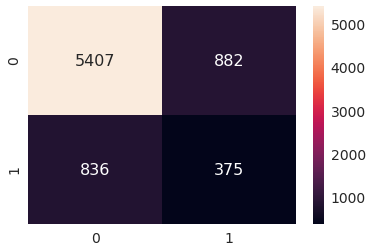

In [80]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=57)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Performance Table

![image](https://image.ibb.co/kokTjJ/6_Decision_Trees.png)

## Conclusions
1. Decision Trees on Uni-gram, bi-gram and tfidf would have taken forever if had taken all the dimensions as it had huge dimension and hence tried with max 300 as max_depth
2. Bi-gram Featurization(max_depth=73) gave the best results with accuracy of 85.11% and F1-score of 0.513
3. Plotted feature importance for Uni-gram, bi-gram and tfidf but not for Avg Word2Vec and Tfidf Avg Word2Vec as Word2Vec featurizations are highly co-related hence can't directly get the feature importance